# Práctica 3

Se importan las librerías.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency

from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# PREPROCESAMIENTO Y TRANSFORMACIÓN DE LOS DATOS

Se carga el dataset de coches.

In [24]:
coches = pd.read_csv("https://github.com/victorinho09/practica3_IA/raw/main/car_price_prediction.csv")
coches.drop(["ID", "Color", "Doors", "Wheel"],axis=1,inplace=True)
coches.head(10)

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,4
5,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,4
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,12
7,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,12
8,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,12
9,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,12


In [25]:
print('El dataset tiene', coches.shape[0], 'filas')
print('El dataset tiene', coches.shape[1], 'columnas')

El dataset tiene 19237 filas
El dataset tiene 14 columnas


Se eliminan nulos, duplicados y otros.

In [26]:
coches.dropna()
coches.drop_duplicates()
coches = coches[coches["Levy"] != "-"]

Además, las columnas de "Manufacturer" y "Model" van estrechamente relacionadas, hasta el punto de que los modelos van asociados a un manufacturer, por lo que no podemos dejar que ese parámetro vaya por libre.

In [27]:
coches["Manufacturer-Model"] = coches["Manufacturer"] + "|" + coches["Model"]
coches.drop(["Model"],axis=1,inplace=True)
coches.drop(["Manufacturer"],axis=1,inplace=True)
coches = coches.reset_index(drop=True)
coches.head()

<ipython-input-27-b854ee6494da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coches["Manufacturer-Model"] = coches["Manufacturer"] + "|" + coches["Model"]
<ipython-input-27-b854ee6494da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coches.drop(["Model"],axis=1,inplace=True)
<ipython-input-27-b854ee6494da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coches.drop(["Manu

,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags,Manufacturer-Model
0,13328,1399,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,12,LEXUS|RX 450
1,16621,1018,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,8,CHEVROLET|Equinox
2,3607,862,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,0,FORD|Escape
3,11726,446,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,4,HONDA|FIT
4,39493,891,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,4,HYUNDAI|Santa FE


Vamos a rectificar el valor de la columna "Mileage", ya que no nos interesa que tenga puesto "km"

In [28]:
coches["Mileage"] = coches['Mileage'].apply(lambda x: x[:-2])

#Eliminamos los valores vacíos
coches = coches[coches["Mileage"] != ""]

#Ahora convertimos a int esa columna (Primero a float para evitar posibles errores de conversión)
coches['Mileage'] = coches['Mileage'].astype(float)
coches['Mileage'] = coches['Mileage'].astype(int)
coches.head()

,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags,Manufacturer-Model
0,13328,1399,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,12,LEXUS|RX 450
1,16621,1018,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,8,CHEVROLET|Equinox
2,3607,862,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,0,FORD|Escape
3,11726,446,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,HONDA|FIT
4,39493,891,2016,Jeep,Yes,Diesel,2,160931,4.0,Automatic,Front,4,HYUNDAI|Santa FE


En la columna Engine volume algun registros contienen el string 'Turbo' a continuación del valor decimal.

In [29]:
# Crear la columna binaria 'Turbo' basada en la presencia de ' Turbo'
coches['Turbo'] = coches['Engine volume'].str.contains(' Turbo').astype(int)

# Eliminar ' Turbo' de 'Engine volume' y convertirlo a valores numéricos
coches['Engine volume'] = coches['Engine volume'].str.replace(' Turbo', '').astype(float)
coches.head()

,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags,Manufacturer-Model,Turbo
0,13328,1399,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,12,LEXUS|RX 450,0
1,16621,1018,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,8,CHEVROLET|Equinox,0
2,3607,862,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,0,FORD|Escape,0
3,11726,446,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,HONDA|FIT,0
4,39493,891,2016,Jeep,Yes,Diesel,2.0,160931,4.0,Automatic,Front,4,HYUNDAI|Santa FE,0


Se normalizan las variables numéricas.

In [30]:
coches[['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']] = MinMaxScaler(feature_range=(0, 1)).fit_transform(coches[['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']])
coches.head()

,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags,Manufacturer-Model,Turbo
0,13328,0.112841,0.818182,Jeep,Yes,Hybrid,0.175,0.000087,0.333333,Automatic,4x4,0.75,LEXUS|RX 450,0
1,16621,0.080072,0.836364,Jeep,No,Petrol,0.150,0.000089,0.333333,Tiptronic,4x4,0.50,CHEVROLET|Equinox,0
2,3607,0.066655,0.836364,Jeep,Yes,Hybrid,0.125,0.000079,0.200000,Automatic,4x4,0.00,FORD|Escape,0
3,11726,0.030876,0.890909,Hatchback,Yes,Petrol,0.065,0.000043,0.200000,Automatic,Front,0.25,HONDA|FIT,0
4,39493,0.069149,0.927273,Jeep,Yes,Diesel,0.100,0.000075,0.200000,Automatic,Front,0.25,HYUNDAI|Santa FE,0


Se estudia la correlación de las variables numéricas.

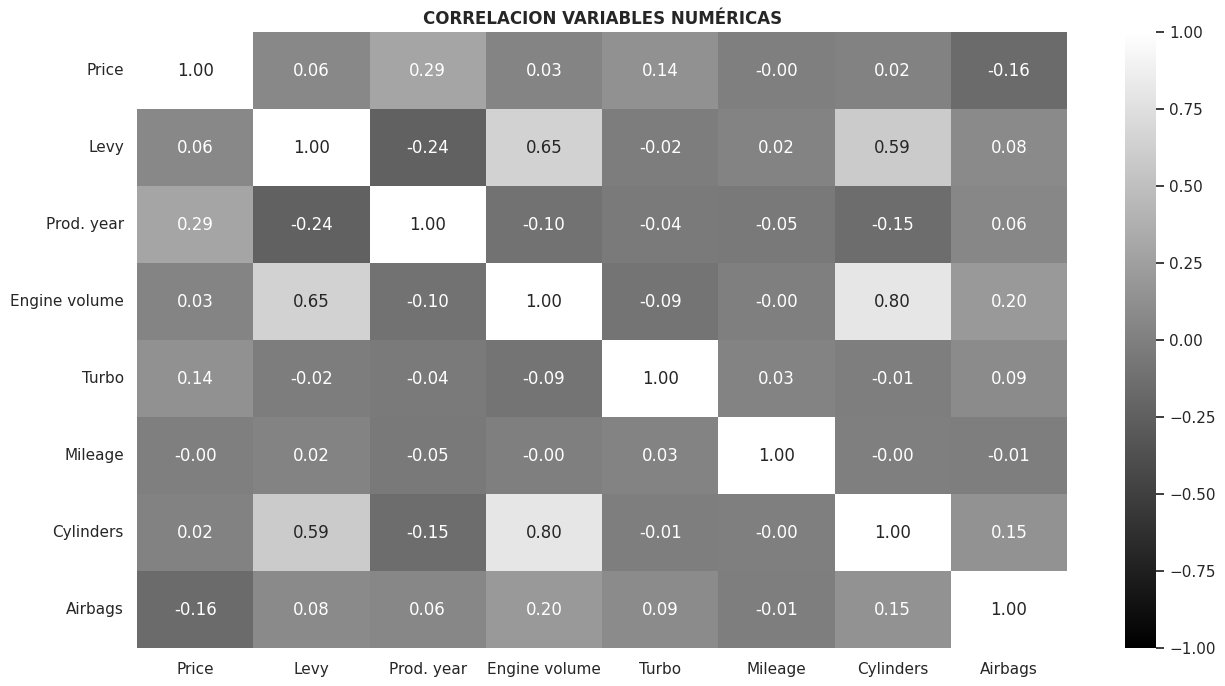

In [31]:
correlacion = pd.DataFrame(coches[['Price', 'Levy', 'Prod. year', 'Engine volume', 'Turbo', 'Mileage', 'Cylinders', 'Airbags']].corr())
fig, ax = plt.subplots(figsize=(15, 8))
sbn.set(style="white", palette="gray")
sbn.heatmap(correlacion, vmin=-1, vmax=1, annot=True, cmap='gray', fmt=".2f");
ax.set_title('CORRELACION VARIABLES NUMÉRICAS', weight='bold')
plt.show()

Se eliminan las que no tienen apenas correlación con la variable objetivo 'Precio'.

(Umbral Mínimo de correlacion utilizado = 0.1)

In [32]:
coches.drop(['Levy', 'Engine volume', 'Mileage', 'Cylinders'],axis=1,inplace=True)

Ahora se estudia la correlación entre Price y las variables categóricas. Para ello hay que crear intervalos con la variable numérica Price

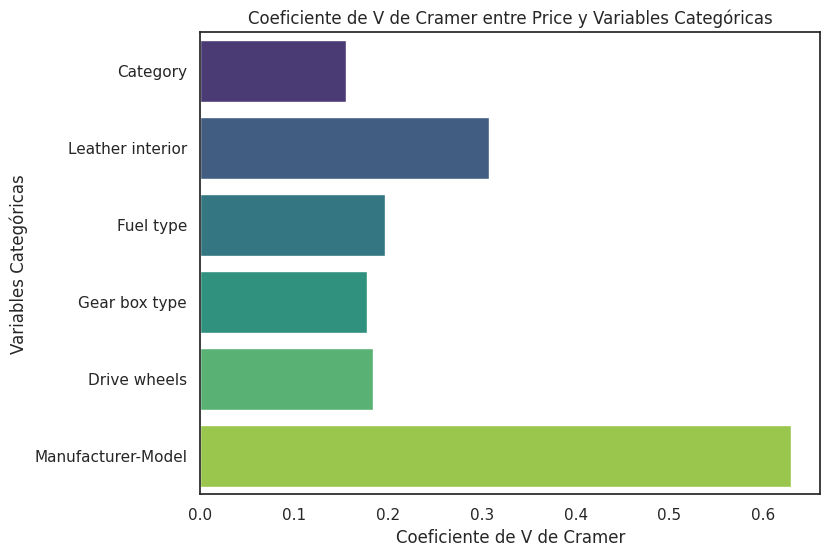

In [33]:
# Convertir la variable numérica 'Price' en intervalos o categorías
Price_Category = pd.cut(coches['Price'], bins=100)

# Seleccionar las variables a comparar
categorical_columns = ['Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Manufacturer-Model']

# Función para calcular el coeficiente de V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))
    return cramer_v

# Calcular coeficientes de V de Cramer para cada variable categórica en relación con 'Price_Category'
cramer_values = []
for column in categorical_columns:
    v_cramer = cramers_v(Price_Category, coches[column])
    cramer_values.append(v_cramer)

# Crear un gráfico de barras para visualizar los coeficientes de V de Cramer
plt.figure(figsize=(8, 6))
sbn.barplot(x=cramer_values, y=categorical_columns, palette='viridis')
plt.xlabel('Coeficiente de V de Cramer')
plt.ylabel('Variables Categóricas')
plt.title('Coeficiente de V de Cramer entre Price y Variables Categóricas')
plt.show()


Se pueden introducir todas al modelo.

Se estudia la distrubución de las variables que se van a introducir al modelo.

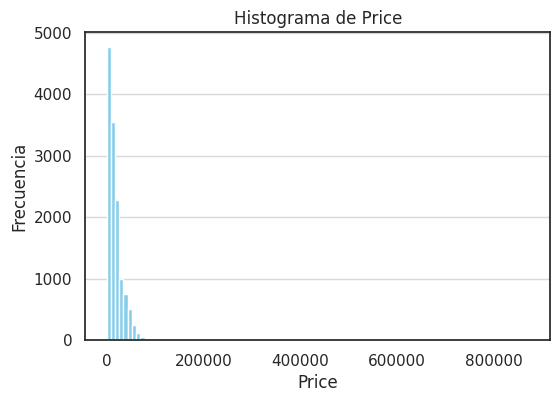

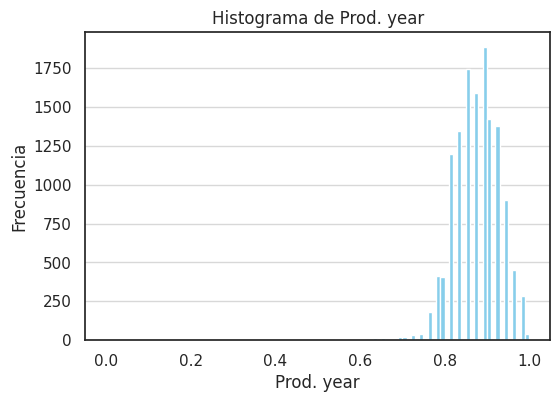

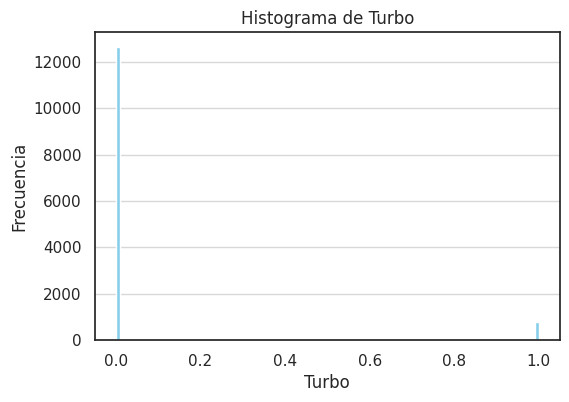

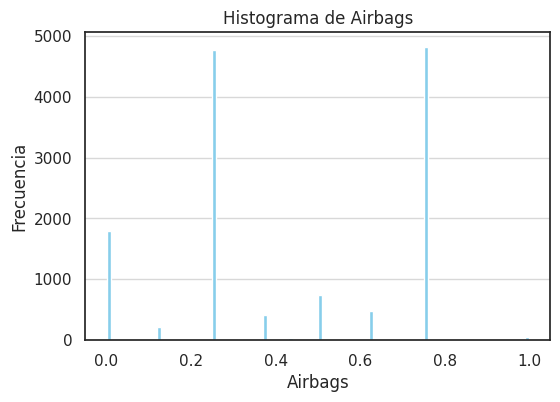

In [34]:
# Selección de las columnas numéricas de interés
numeric_columns = ['Price', 'Prod. year', 'Turbo', 'Airbags']

# Crear histogramas para cada variable numérica
for column in numeric_columns:
    plt.figure(figsize=(6, 4))
    plt.hist(coches[column], bins=100, color='skyblue')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

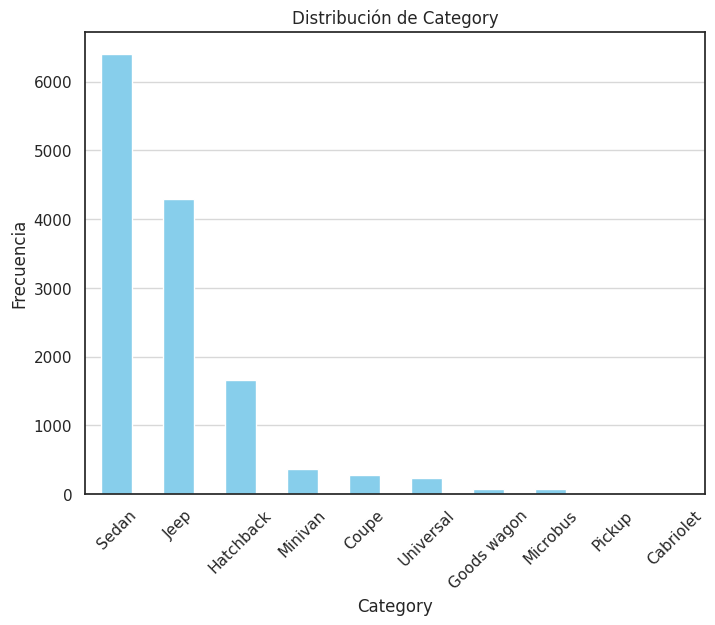

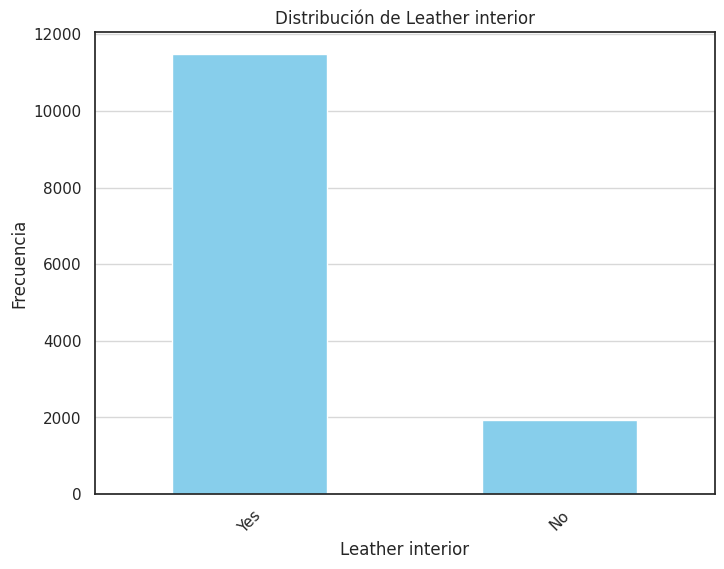

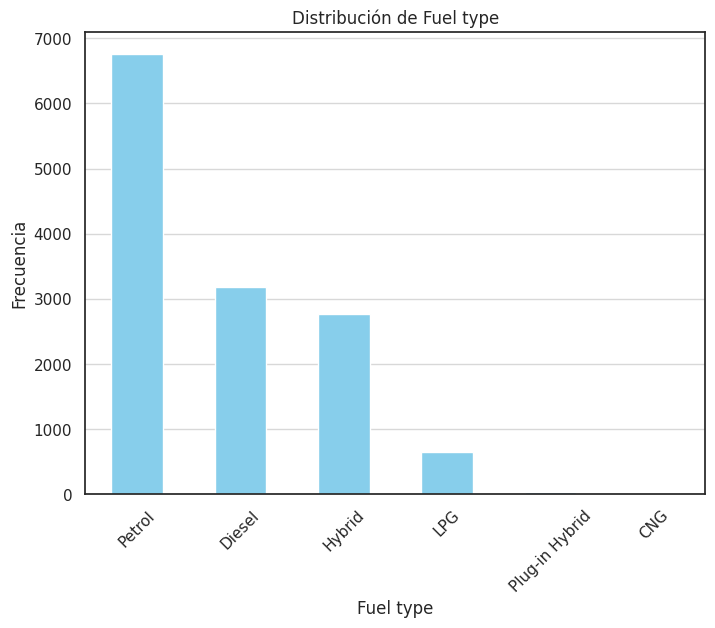

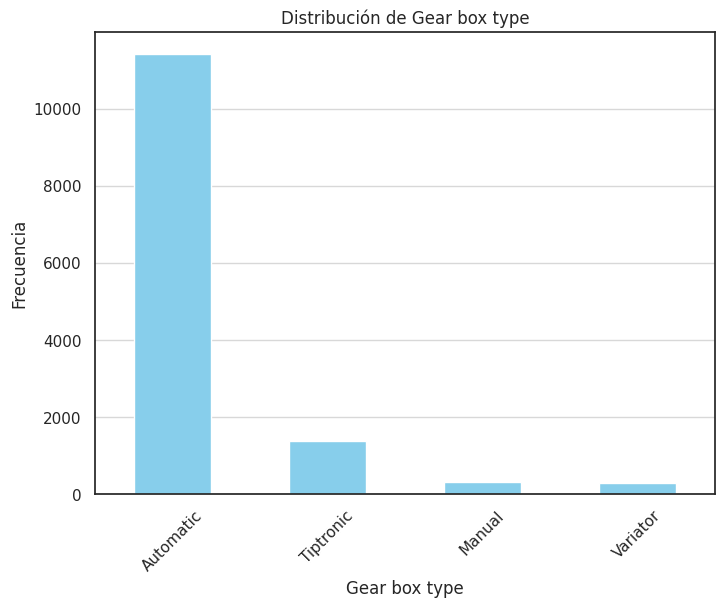

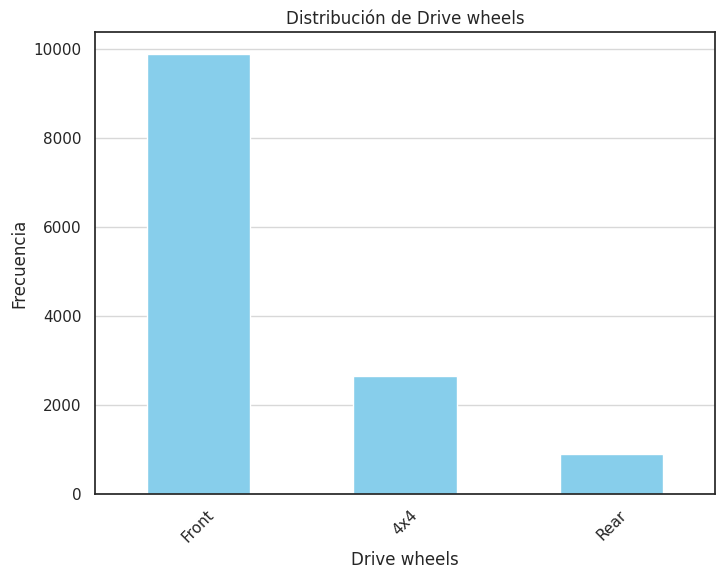

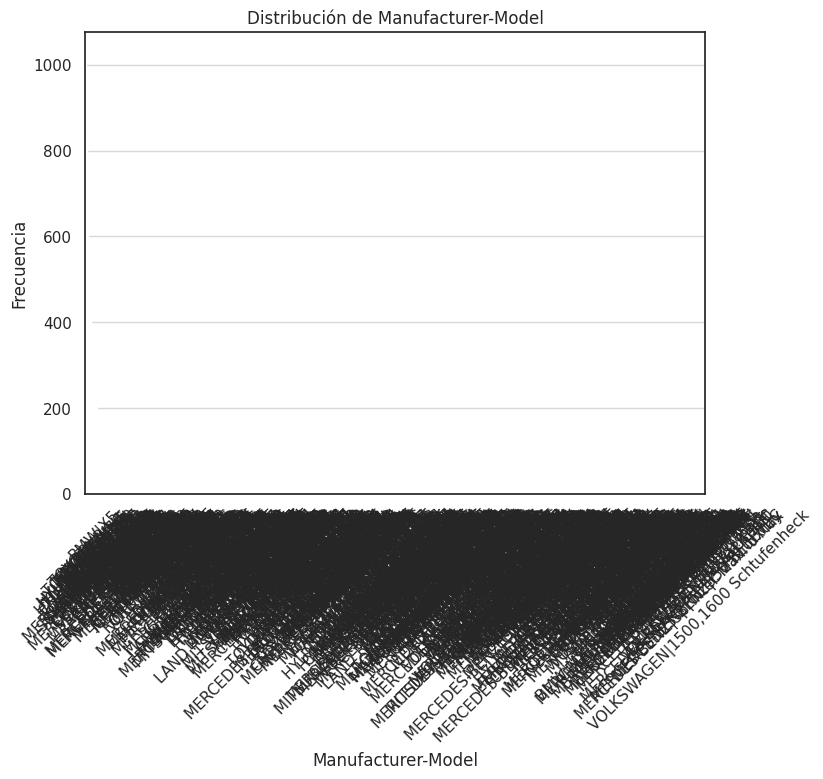

In [35]:
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    coches[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)  # Rotar etiquetas del eje x para una mejor visualización
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Hay muchas variables tanto numéricas como categóricas que no tienen una distribución equilibrada. Esto afectará al entrenamiento de los modelos.

Se obtienen las dummies de las variables categóricas.

En el caso de Manufacturer-Model, al existir tantas clases dentro de esta categoría, se factoriza asignándole un número entero a cada clase. Para que este paso funcione mejor, a la clase que menos correlación tenga con Price se le asigna 0, a la siguiente 1,...

In [36]:
# DUMMIES
columns_to_encode = ['Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels']

# Codificar las columnas seleccionadas en 'coches' usando get_dummies
coches = pd.get_dummies(coches, columns=columns_to_encode, drop_first=True)


# FACTORIZACIÓN
# Función para calcular el coeficiente de V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

manufacturer_model_unique = coches['Manufacturer-Model'].unique()

# Calcular el coeficiente de V de Cramer para cada clase única de 'Manufacturer-Model' con 'Price'
cramer_corr = {}
for category in manufacturer_model_unique:
    mask = coches['Manufacturer-Model'] == category
    cramer_corr[category] = cramers_v(mask, coches['Price'])

# Ordenar las clases por su correlación con 'Price'
sorted_classes = sorted(cramer_corr, key=cramer_corr.get)

# Asignar valores numéricos basados en la correlación
assigned_values = {model: i for i, model in enumerate(sorted_classes)}

# Factorizar 'Manufacturer-Model' usando los valores asignados
coches['Manufacturer-Model_Factorized'] = coches['Manufacturer-Model'].map(assigned_values)
coches.drop(['Manufacturer-Model'],axis=1,inplace=True)

coches.head()

,Price,Prod. year,Airbags,Turbo,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Microbus,Category_Minivan,...,Fuel type_Hybrid,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_Front,Drive wheels_Rear,Manufacturer-Model_Factorized
0,13328,0.818182,0.75,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,629
1,16621,0.836364,0.50,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,3607,0.836364,0.00,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,11726,0.890909,0.25,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,720
4,39493,0.927273,0.25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,760


Se crean las divisiones del cross validation

In [37]:
# Establecer el número de divisiones para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 divisiones con barajado aleatorio
X = coches.iloc[:, 1:]
X[['Manufacturer-Model_Factorized']] = MinMaxScaler(feature_range=(0, 1)).fit_transform(X[['Manufacturer-Model_Factorized']])
y = coches.iloc[:, [0]]

X = X.values
y = y.values

In [38]:
# Se inicializan los resultados de los modelos
promedio_mae = np.zeros(5)
r2 = np.zeros(5)

# MODELOS DE REGRESIÓN

##1. SVR

In [40]:
# Creamos el modelo SVR
m1 = svm.SVR(kernel='poly')

# Realizar la validación cruzada y obtener los puntajes MAE y R^2
mae_scores = -cross_val_score(m1, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(m1, X, y, cv=kf, scoring='r2')

# Calcular el promedio de los puntajes de MAE y R^2
promedio_mae[0] = mae_scores.mean()
r2[0] = r2_scores.mean()

print(f"MAE promedio: {promedio_mae[0]}")
print(f"R^2 promedio: {r2[0]}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

MAE promedio: 11845.982024916044
R^2 promedio: 0.0029920821684857658


##2. Random Forest de regresión

In [41]:
# Se crea un modelo de Random Forest de regresión
m2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Realizar la validación cruzada y obtener los puntajes MAE y R^2
mae_scores = -cross_val_score(m2, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(m2, X, y, cv=kf, scoring='r2')

# Calcular el promedio de los puntajes de MAE y R^2
promedio_mae[1] = mae_scores.mean()
r2[1] = r2_scores.mean()

print(f"MAE promedio: {promedio_mae[1]}")
print(f"R^2 promedio: {r2[1]}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

MAE promedio: 5281.206488760188
R^2 promedio: 0.6069495787465751


##3. Árbol de Decisión de regresión

In [42]:
# Se crea un modelo de árbol de decisión de regresión
m3 = DecisionTreeRegressor(max_depth=5)

# Realizar la validación cruzada y obtener los puntajes MAE y R^2
mae_scores = -cross_val_score(m3, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(m3, X, y, cv=kf, scoring='r2')

# Calcular el promedio de los puntajes de MAE y R^2
promedio_mae[2] = mae_scores.mean()
r2[2] = r2_scores.mean()

print(f"MAE promedio: {promedio_mae[2]}")
print(f"R^2 promedio: {r2[2]}")

MAE promedio: 8208.102879712953
R^2 promedio: 0.01945393411503238


##4. Gradient Boosting de regresión

In [43]:
# Se crea un modelo de Gradient Boosting de regresión
m4 = GradientBoostingRegressor(n_estimators=100, subsample=1, learning_rate=0.1, max_depth=10, max_features=24, random_state=42)

# Realizar la validación cruzada y obtener los puntajes MAE y R^2
mae_scores = -cross_val_score(m4, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(m4, X, y, cv=kf, scoring='r2')

# Calcular el promedio de los puntajes de MAE y R^2
promedio_mae[3] = mae_scores.mean()
r2[3] = r2_scores.mean()

print(f"MAE promedio: {promedio_mae[3]}")
print(f"R^2 promedio: {r2[3]}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

MAE promedio: 5353.642183727198
R^2 promedio: 0.47451121820252684


##5. Extra Trees Regressor

In [44]:
# Se crea un modelo de Extra Trees Regressor
m5 = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Realizar la validación cruzada y obtener los puntajes MAE y R^2
mae_scores = -cross_val_score(m5, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(m5, X, y, cv=kf, scoring='r2')

# Calcular el promedio de los puntajes de MAE y R^2
promedio_mae[4] = mae_scores.mean()
r2[4] = r2_scores.mean()

print(f"MAE promedio: {promedio_mae[4]}")
print(f"R^2 promedio: {r2[4]}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

MAE promedio: 5181.2887956406985
R^2 promedio: 0.6694356646147185


# Ensamblado de modelos

In [45]:
from sklearn.ensemble import VotingRegressor

# Se crea un modelo realizando la media de los 2 mejores modelos
# (Random Forest de regresión y Extra Trees Regressor)
m = VotingRegressor([('rf', m2), ('et', m5)])

# Realizar la validación cruzada y obtener los puntajes MAE y R^2
mae_scores = -cross_val_score(m, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(m, X, y, cv=kf, scoring='r2')

# Calcular el promedio de los puntajes de MAE y R^2
promedio_mae_final = mae_scores.mean()
r2_final = r2_scores.mean()

print(f"MAE promedio: {promedio_mae_final}")
print(f"R^2 promedio: {r2_final}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

MAE promedio: 5153.449116858561
R^2 promedio: 0.668359221541681
